# ERC-4626: analyse single vault

- In this notebook, we examine a single or handful of handpicked ERC-4626 vaults
    - Vaults are picked manually by (chain, address) list
    - We analyse the vault performance by its share price, as reported by ERC-4626 smart contract interface.    
    - We do last three months and historical all-time analyses
    - We look [quantitative finance](https://tradingstrategy.ai/glossary/quantitative-finance) aspects of the vaults like [returns](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr), [Sharpe](https://tradingstrategy.ai/glossary/sharpe) and [Sortino](https://tradingstrategy.ai/glossary/sortino) numbers    

Some notes
- Because of how vault metrics, share price and such are collected and interpreted, the results in this notebook contain various inaccuracies.
- In this notebook, we use terms Net Asset Value (NAV) and [Total Value Locked (TVL)](https://tradingstrategy.ai/glossary/total-value-locked-tvl) interchangeably.

## Usage

This is an open source notebook based on open data
- You can edit and remix this notebook yourself 

To do your own data research:

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices-1h.parquet` file.

For any questions, follow and contact [Trading Strategy community](https://tradingstrategy.ai/community).

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [7]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

try:
    # Optionally make charts easier to share on Twitter
    from tradeexecutor.utils.notebook import set_large_plotly_chart_font

    set_large_plotly_chart_font(line_width=5, legend_font_size=16)
    pio.templates.default = "custom"
except ImportError:
    print("Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. ")
    pio.templates.default = "plotly_white"

Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. 


## Read and clean raw scanned vault price data

- Read the Parquet file produced earlier with price scan 
- Clean the data if necessary

In [8]:
import pickle
from pathlib import Path

from eth_defi.vault.vaultdb import VaultDatabase

data_folder = Path("~/.tradingstrategy/vaults").expanduser()
vault_db_path = data_folder / "vault-db.pickle"

vault_db: VaultDatabase = pickle.load(open(vault_db_path, "rb"))

cleaned_data_parquet_file = data_folder / "cleaned-vault-prices-1h.parquet"
prices_df = pd.read_parquet(cleaned_data_parquet_file)

print(f"We have {len(vault_db):,} vaults in the database and {len(prices_df):,} price rows.")

We have 10,357 vaults in the database and 8,393,611 price rows.


## Choose vaults to examine

- We pick vaults to examine and compare by chain and address tuples

In [9]:
from eth_defi.vault.base import VaultSpec


VAULTS = [
    # Harvest USDC Autopilot on IPOR on Base
    # https://app.ipor.io/fusion/base/0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4/settings
    VaultSpec(8453, "0x0d877Dc7C8Fa3aD980DfDb18B48eC9F8768359C4"),
    # IPOR USDC base
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    VaultSpec(8453, "0x45aa96f0b3188d47a1dafdbefce1db6b37f58216"),
    # gTRADE (Gains) on Polygon
    # https://app.ipor.io/fusion/base/0x45aa96f0b3188d47a1dafdbefce1db6b37f58216
    VaultSpec(137, "0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81"),

    # Gains on ARbitrum
    # 42161-0xd85e038593d7a098614721eae955ec2022b9b91b
    VaultSpec(42161, "0xd85e038593d7a098614721eae955ec2022b9b91b"),

    # Peapods arbitrum
    VaultSpec(42161, "0xc2810eb57526df869049fbf4c541791a3255d24c"),

    # Degen pool USDC 42161-0x20a1012b79e8f3ca3f802533c07934ef97398da
    VaultSpec(42161, "0x20a1012b79e8f3ca3f802533c07934ef97398da7"),

    # Fluegel DAO
    # 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
    # https://fluegelcoin.com/dashboard
    VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c"),    
]

## Examine data

- Examine data rows available

In [10]:
examined_vault_spec = VAULTS[0]
examined_id = f"{examined_vault_spec.chain_id}-{examined_vault_spec.vault_address}"
vault_df = prices_df[prices_df["id"] == examined_id]

vault_metadata = vault_db[examined_vault_spec]

print(f"Data for vault {examined_id}, {vault_metadata['Name']} ({vault_metadata['Symbol']}) has {len(vault_df):,} rows.")
display(vault_df.head(3))

Data for vault 8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4, Autopilot USDC Base (bAutopilot_USDC) has 3,083 rows.


chain                                     address  \
timestamp                                                                
2025-03-03 21:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-03-05 17:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-03-05 18:02:57   8453  0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   

                     block_number  share_price  total_assets  total_supply  \
timestamp                                                                    
2025-03-03 21:02:57      27123215         1.00        100.97        100.97   
2025-03-05 17:02:57      27202415         1.00        300.97        300.97   
2025-03-05 18:02:57      27204215         1.00        300.97        300.97   

                     performance_fee  management_fee errors  \
timestamp                                                     
2025-03-03 21:02:57             0.02            0.00          
2025-03-05 17:02:57             0.02            0.00          
2025-03-05 18:02:57             0.02            0.00          

                                                                  id  \
timestamp                                                              
2025-03-03 21:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-03-05 17:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   
2025-03-05 18:02:57  8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4   

                                    name  event_count protocol  \
timestamp                                                        
2025-03-03 21:02:57  Autopilot USDC Base         3239     IPOR   
2025-03-05 17:02:57  Autopilot USDC Base         3239     IPOR   
2025-03-05 18:02:57  Autopilot USDC Base         3239     IPOR   

                     raw_share_price  pct_change_prev  pct_change_next  \
timestamp                                                                
2025-03-03 21:02:57             1.00              NaN             0.00   
2025-03-05 17:02:57             1.00             0.00             0.00   
2025-03-05 18:02:57             1.00             0.00             0.00   

                     returns_1h  avg_assets_by_vault  dynamic_tvl_threshold  \
timestamp                                                                     
2025-03-03 21:02:57        0.00         2,586,857.52              51,737.15   
2025-03-05 17:02:57        0.00         2,586,857.52              51,737.15   
2025-03-05 18:02:57        0.00         2,586,857.52              51,737.15   

                     tvl_filtering_mask  
timestamp                                
2025-03-03 21:02:57                True  
2025-03-05 17:02:57                True  
2025-03-05 18:02:57                True

## Vault charts and performance tearsheets

- Examine vault metrics and charts

Examining vault Autopilot USDC Base: 8453-0x0d877dc7c8fa3ad980dfdb18b48ec9f8768359c4, having 3,083 raw returns, 3,082 hourly and 137 daily returns
Share price movement: 1.0000 2025-03-03 21:02:57 -> 1.0293 2025-07-19 18:02:57


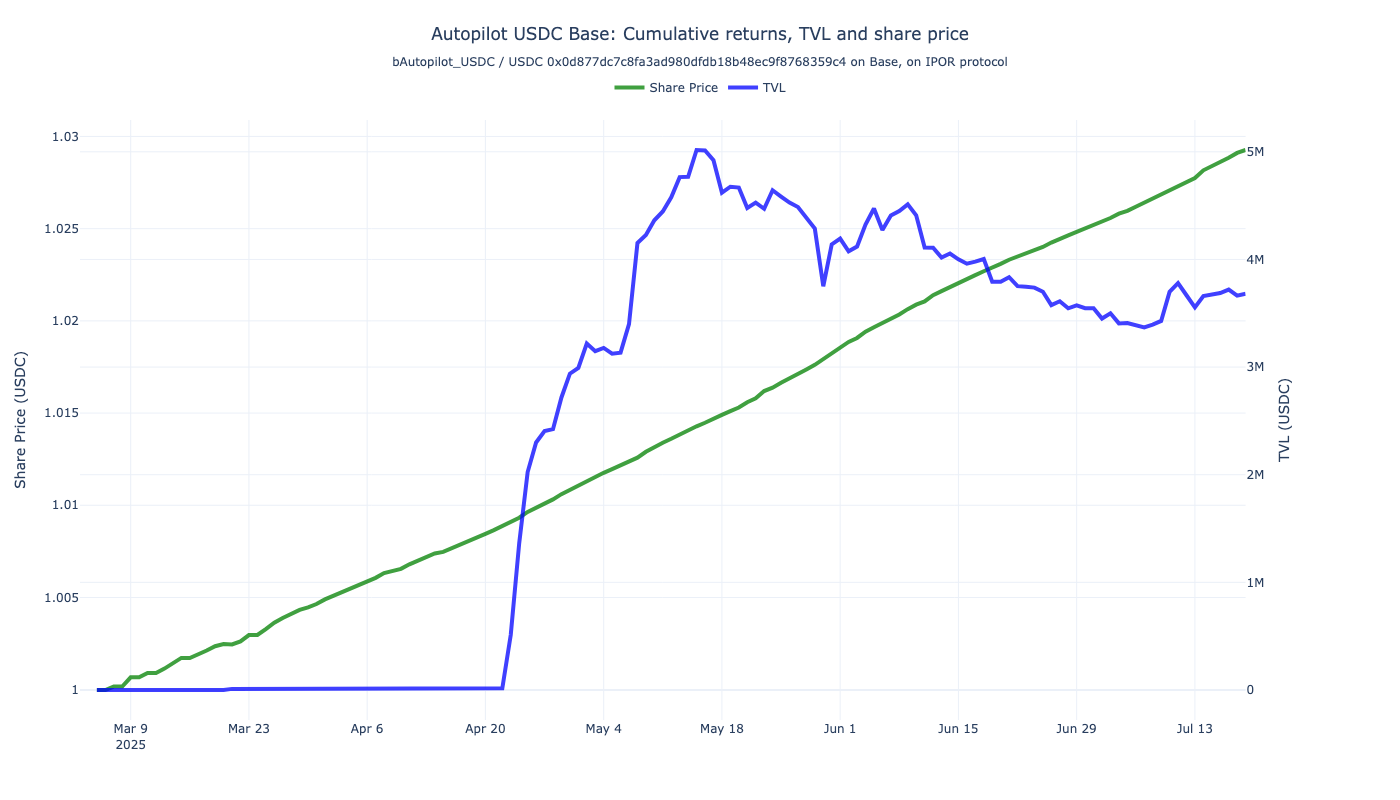

Stats for Autopilot USDC Base from 2025-03-03 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2.93%              43.15  7.93%   -0.00%

Annualized Returns:
mtd    3m     6m    ytd    1y    3y    5y    10y    incep.
-----  -----  ----  -----  ----  ----  ----  -----  --------
0.42%  2.08%  -     2.93%  -     -     -     -      7.93%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  43.15    15.38      -
mean    5.31%    7.29%      -
vol     0.12%    0.47%      -
skew    -0.48    -1.25      -
kurt    3.25     1.96       -
best    0.05%    0.74%      -
worst   -0.00%   0.42%      -

Drawdowns:
max     avg       # days
------  ------  --------
-0.00%  -0.00%      1.17

Misc:
---------------  -----
avg. up month    0.61%
avg. down month  -
up year %        -
12m up %         -
---------------  -----
Examining vault IPOR USDC

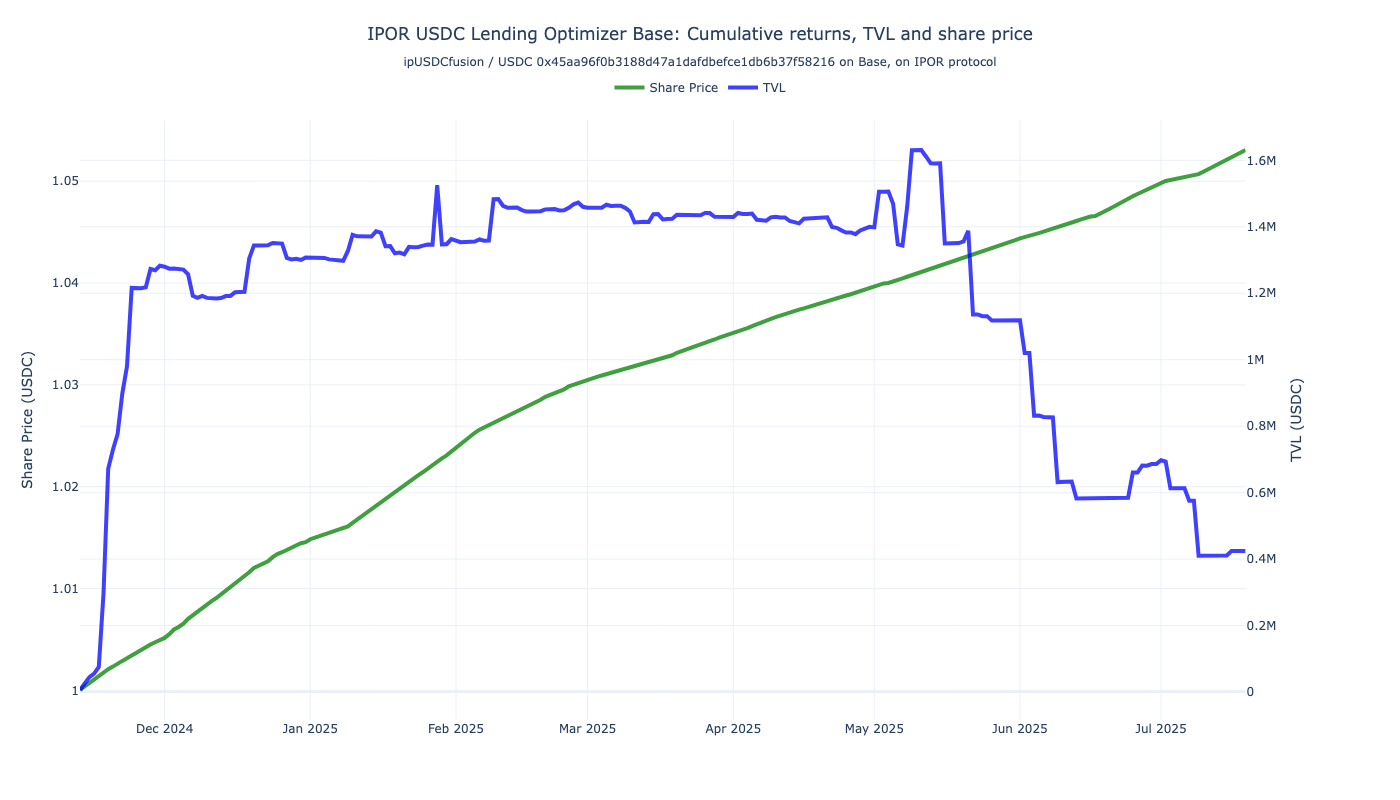

Stats for IPOR USDC Lending Optimizer Base from 2024-11-13 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
5.30%              37.89  7.91%   0.00%

Annualized Returns:
mtd    3m     6m     ytd    1y    3y    5y    10y    incep.
-----  -----  -----  -----  ----  ----  ----  -----  --------
0.33%  1.46%  3.30%  3.80%  -     -     -     -      7.91%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  37.89    8.96       -
mean    5.25%    7.04%      3.80%
vol     0.14%    0.79%      -
skew    0.78     0.80       -
kurt    -0.21    -0.83      -
best    0.05%    0.95%      3.80%
worst   0.00%    0.33%      3.80%

Drawdowns:
max    avg    # days
-----  -----  --------
0.00%  -      -

Misc:
---------------  -------
avg. up month    0.59%
avg. down month  -
up year %        100.00%
12m up %         -
---------------  -------
Exa

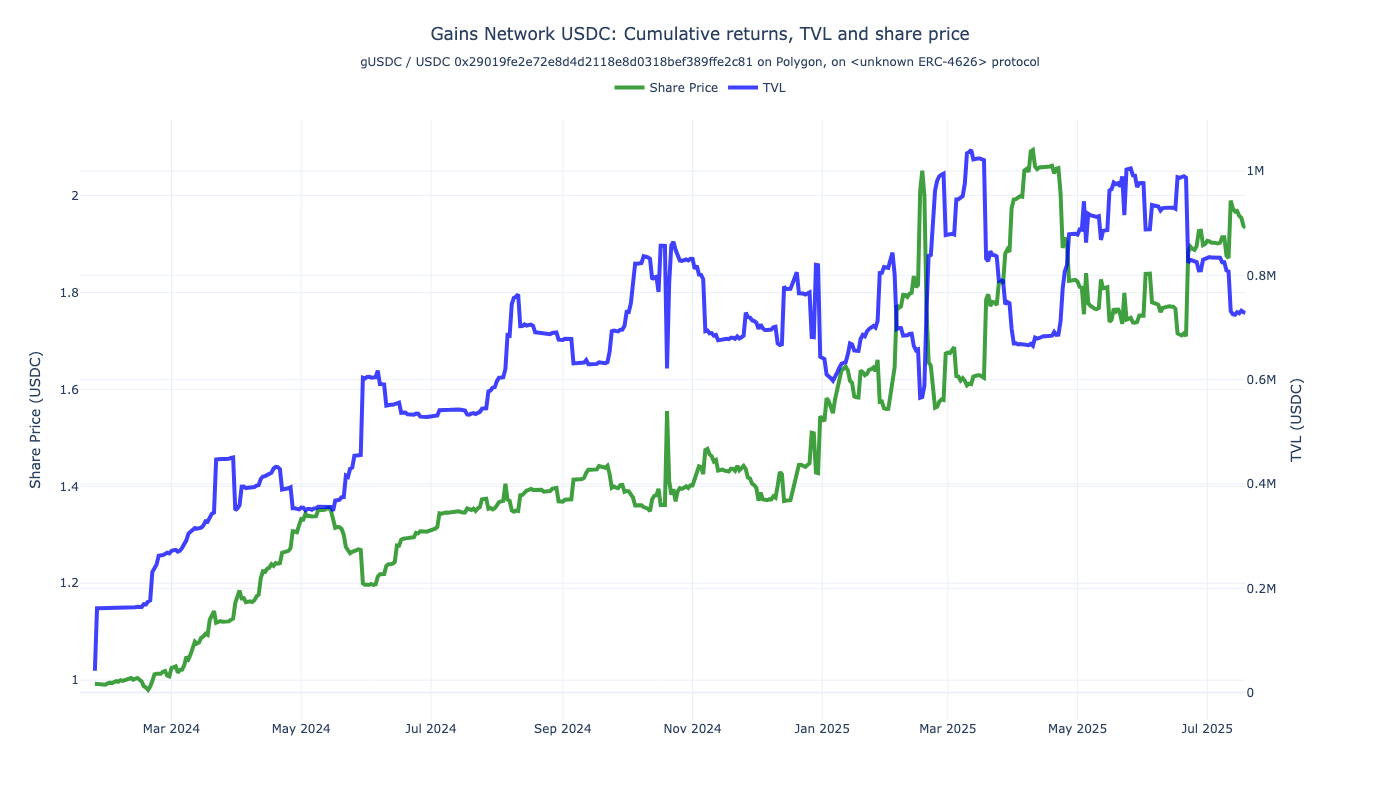

Stats for Gains Network USDC from 2024-01-18 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
93.34%              1.23  55.18%  -23.84%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y    5y    10y    incep.
-----  ------  ------  ------  ------  ----  ----  -----  --------
1.75%  -6.21%  17.96%  25.17%  42.90%  -     -     -      55.18%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.23     1.87       -
mean    34.52%   48.25%     25.17%
vol     27.98%   25.83%     -
skew    1.36     0.14       -
kurt    20.25    -0.40      -
best    14.21%   17.94%     25.17%
worst   -11.86%  -9.32%     25.17%

Drawdowns:
max      avg       # days
-------  ------  --------
-23.84%  -3.00%     13.17

Misc:
---------------  -------
avg. up month    6.22%
avg. down month  -6.96%
up year %        100.00%
12m up %         

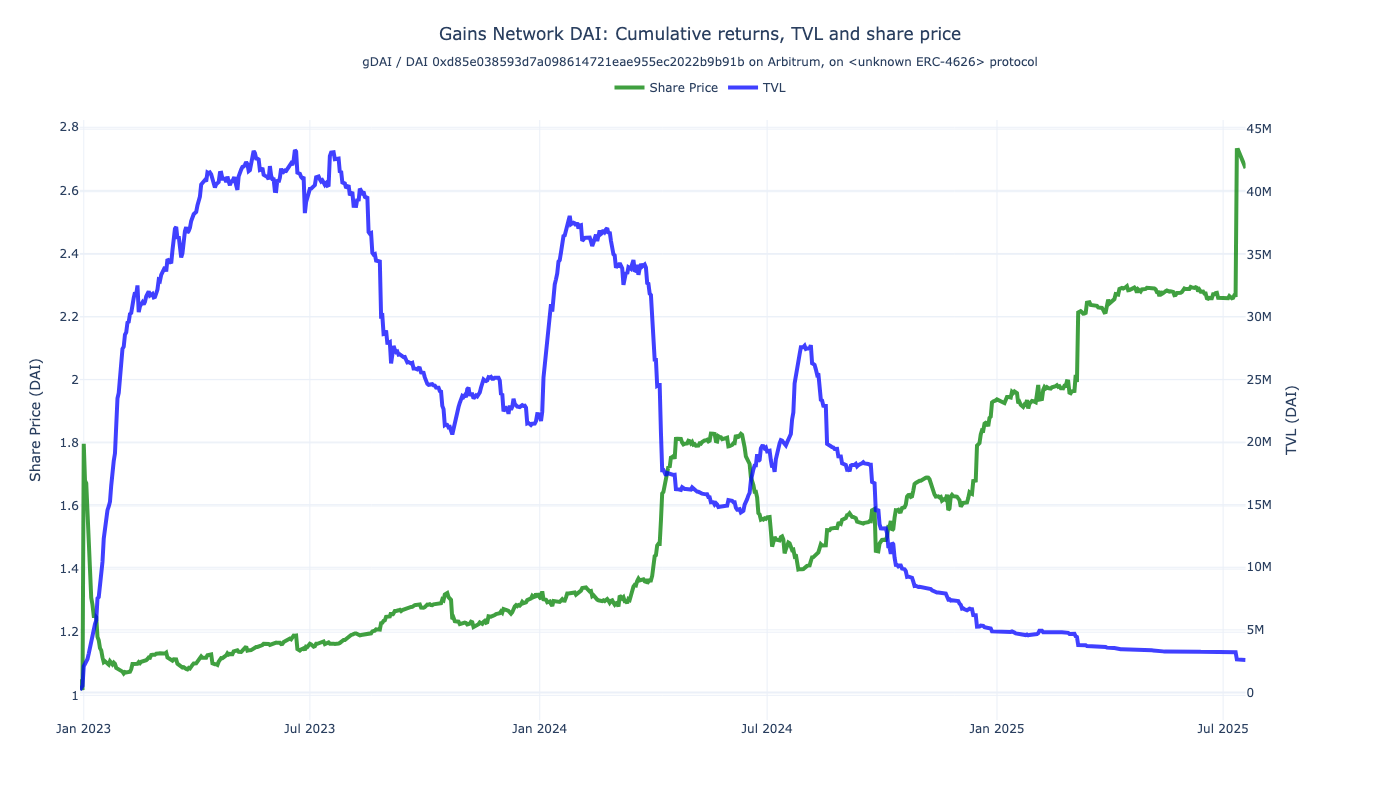

Stats for Gains Network DAI from 2022-12-29 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
154.17%             0.73  44.08%  -40.51%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y      5y    10y    incep.
------  ------  ------  ------  ------  ------  ----  -----  --------
18.18%  16.88%  38.41%  38.05%  80.21%  44.08%  -     -      44.08%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.73     1.39       4.44
mean    32.26%   42.03%     38.15%
vol     44.10%   30.21%     8.59%
skew    22.93    1.15       0.05
kurt    624.80   2.42       -
best    76.72%   30.99%     46.78%
worst   -8.32%   -12.84%    29.61%

Drawdowns:
max      avg       # days
-------  ------  --------
-40.51%  -3.84%     40.64

Misc:
---------------  -------
avg. up month    7.50%
avg. down month  -3.77%
up year %        100.00%

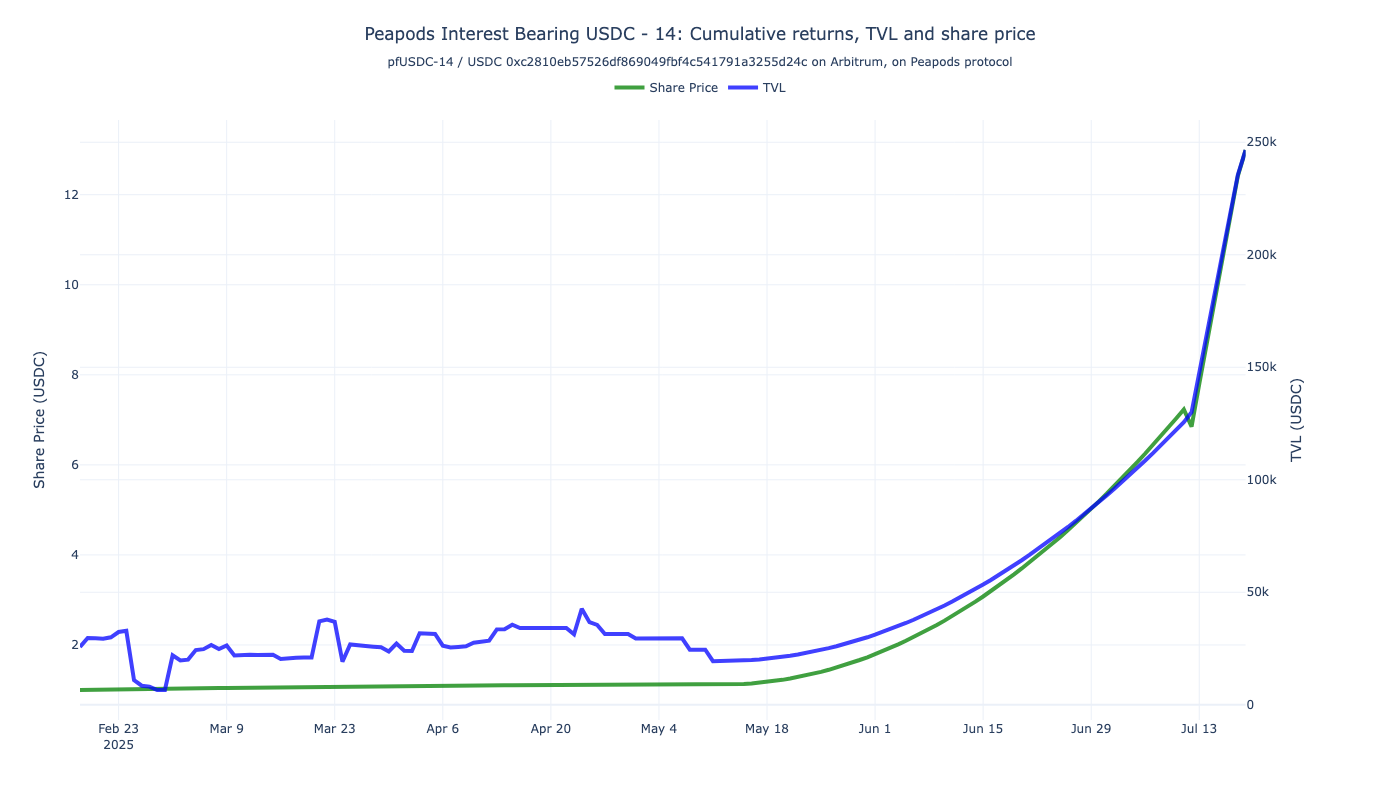

Stats for Peapods Interest Bearing USDC - 14 from 2025-02-18 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR       Max Drawdown
--------------  --------  ---------  --------------
1199.24%           11.16  49316.35%  -5.27%

Annualized Returns:
mtd      3m        6m    ytd       1y    3y    5y    10y    incep.
-------  --------  ----  --------  ----  ----  ----  -----  ---------
150.34%  1071.88%  -     1199.24%  -     -     -     -      49316.35%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  11.16    3.23       -
mean    438.95%  994.78%    -
vol     39.32%   307.64%    -
skew    1.87     0.56       -
kurt    6.04     -2.18      -
best    13.84%   200.52%    -
worst   -5.27%   2.13%      -

Drawdowns:
max     avg       # days
------  ------  --------
-5.27%  -5.27%         1

Misc:
---------------  ------
avg. up month    82.90%
avg. down month  -
up year %        -
12m up %    

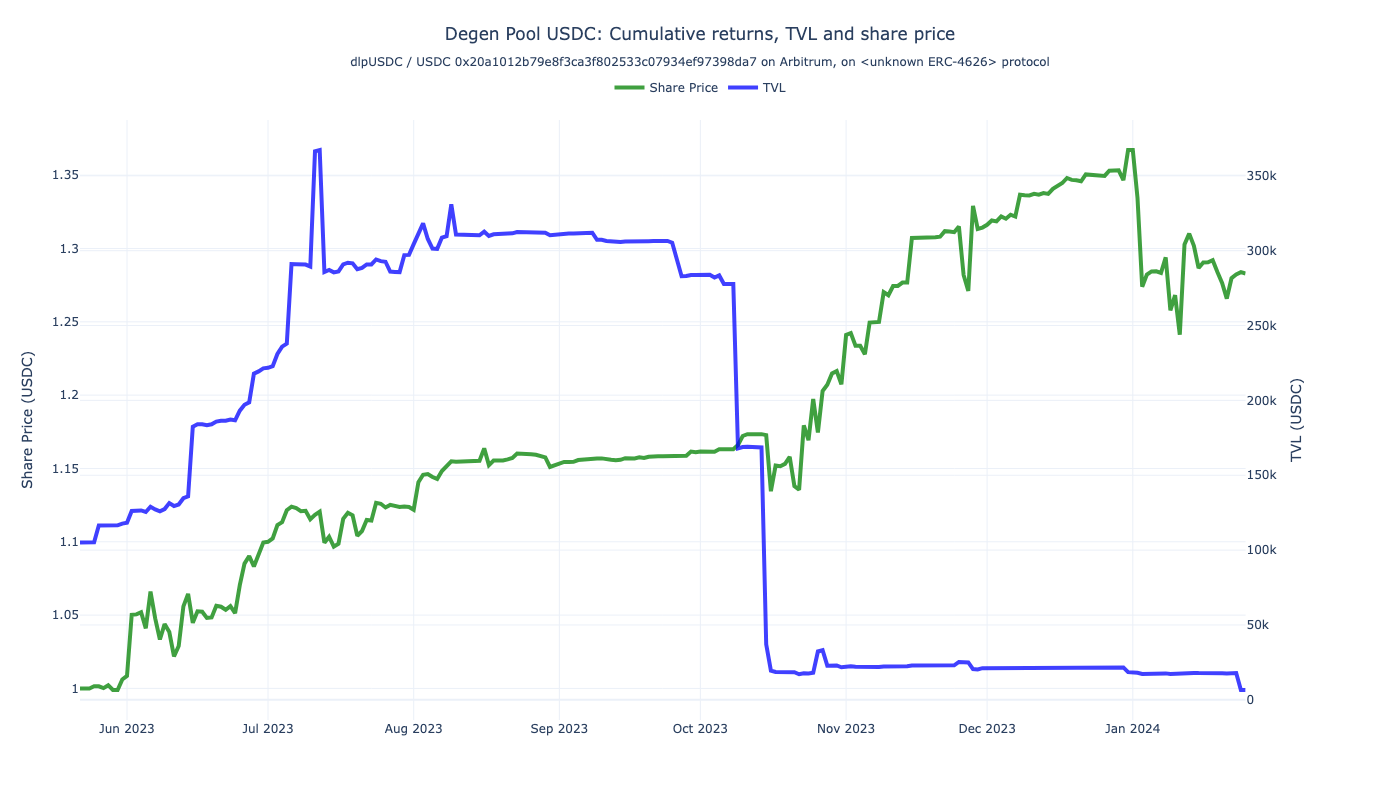

Stats for Degen Pool USDC from 2023-05-22 00:00:00 - 2024-01-25 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
28.29%              1.69  44.33%  -9.21%

Annualized Returns:
mtd     3m     6m      ytd     1y    3y    5y    10y    incep.
------  -----  ------  ------  ----  ----  ----  -----  --------
-6.16%  7.15%  13.95%  -6.16%  -     -     -     -      44.33%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.69     2.27       -
mean    26.55%   38.24%     -6.16%
vol     15.67%   16.83%     -
skew    0.73     -0.70      -
kurt    8.06     1.31       -
best    4.96%    9.28%      -6.16%
worst   -4.55%   -6.16%     -6.16%

Drawdowns:
max     avg       # days
------  ------  --------
-9.21%  -1.19%      6.29

Misc:
---------------  ------
avg. up month    4.52%
avg. down month  -6.16%
up year %        0.00%
12m up %         -
--------------

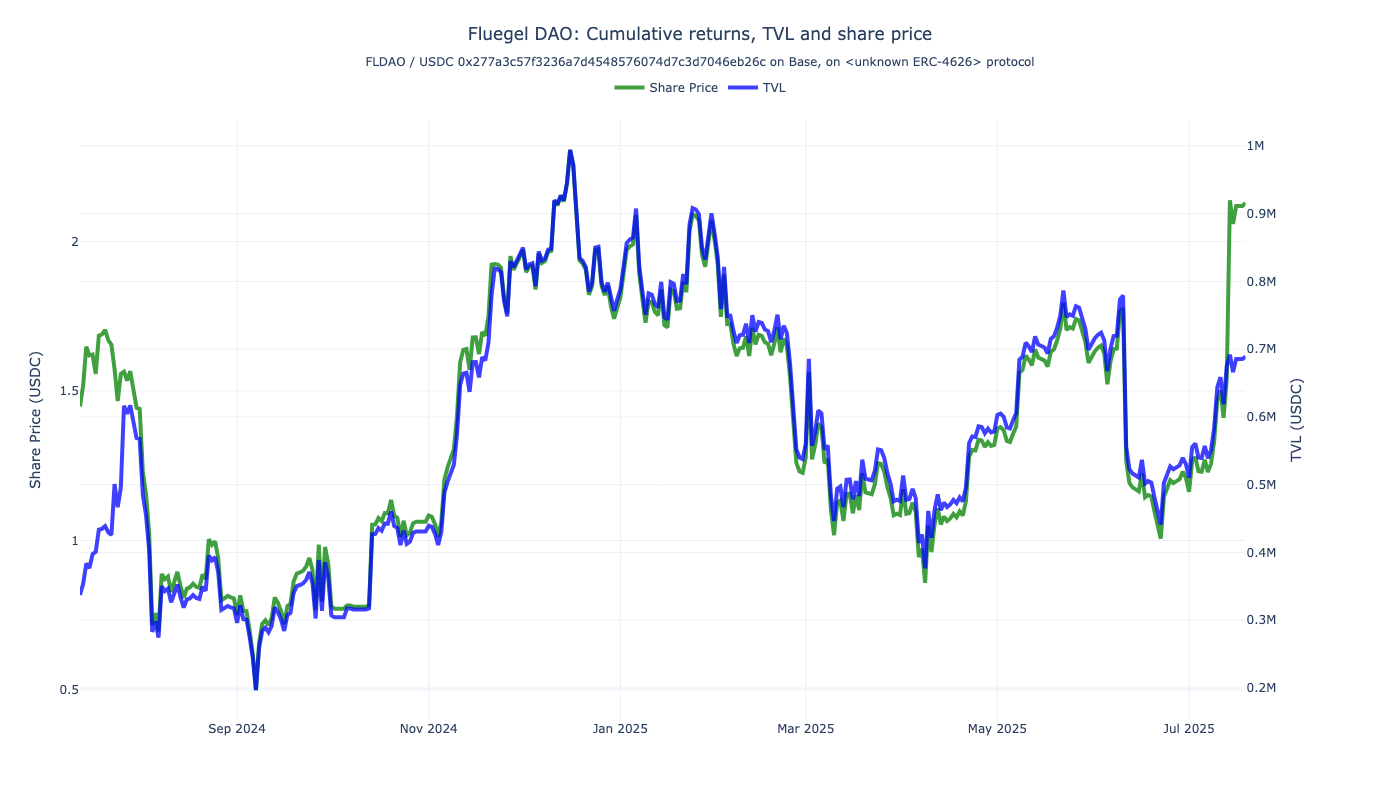

Stats for Fluegel DAO from 2024-07-13 00:00:00 - 2025-07-19 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
46.98%              0.78  46.10%  -70.64%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y    5y    10y    incep.
------  ------  ------  ------  ------  ----  ----  -----  --------
76.01%  93.99%  19.94%  19.54%  26.33%  -     -     -      46.10%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.78     0.85       -
mean    86.05%   117.21%    19.54%
vol     110.98%  137.84%    -
skew    0.95     0.63       -
kurt    7.58     0.01       -
best    38.84%   83.30%     19.54%
worst   -30.00%  -44.14%    19.54%

Drawdowns:
max      avg        # days
-------  -------  --------
-70.64%  -19.76%      44.5

Misc:
---------------  -------
avg. up month    35.04%
avg. down month  -25.62%
up year %        100.00%
12m up %        

In [11]:
from eth_defi.research.vault_metrics import analyse_vault

for vault_spec in VAULTS:
    
    vault_report = analyse_vault(
        vault_db=vault_db,
        prices_df=prices_df,
        spec=vault_spec,
        chart_frequency="daily",
    )

    # Display returns figur
    returns_chart_fig = vault_report.rolling_returns_chart
    returns_chart_fig.show()

    # Display FFN stats
    performance_stats = vault_report.performance_stats
    if performance_stats is not None:
        performance_stats.display()
    else:
        print(f"Vault {vault_spec.chain_id}-{vault_spec.vault_address}: performance metrics not available, is quantstats library installed?")

## Raw vault data

- Examine raw data of a single vault
- Find abnormal return rows

In [12]:
# Fluegel DAO
# 8453-0x277a3c57f3236a7d4548576074d7c3d7046eb26c
# https://fluegelcoin.com/dashboard
vault_spec = VaultSpec(8453, "0x277a3c57f3236a7d4548576074d7c3d7046eb26c")

df = prices_df[prices_df["id"] == vault_spec.as_string_id()]

# 10% claimed hourly returns
mask = df["returns_1h"].abs() > 0.10
expanded_mask = (mask | mask.shift(1) | mask.shift(-1) ).fillna(False)

df = df[expanded_mask]  # Filter out rows with small returns

display(df)

chain                                     address  \
timestamp                                                                
2024-07-27 01:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-07-27 02:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-07-27 03:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-07-27 04:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 01:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 02:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 03:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 04:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 14:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 15:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 16:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 20:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 21:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-05 22:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-14 12:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-14 13:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-14 14:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-14 15:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-17 05:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-17 06:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-17 07:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-17 08:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-21 17:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-21 18:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-21 19:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-08-21 20:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-01 07:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-01 08:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-01 09:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-01 10:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-07 21:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-07 22:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-07 23:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-08 01:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-08 02:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-08 03:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-26 15:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-26 16:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-26 17:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-27 18:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-27 19:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-27 20:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-28 21:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-28 22:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-28 23:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-29 00:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-29 01:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-09-29 02:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-10-01 14:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-10-01 15:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-10-01 16:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-10-01 17:02:57   8453  0x277a3c57f3236a7d4548576074d7c3d7046eb26c   
2024-10-01 19:02:57   845